In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from drawarrow import ax_arrow
from highlight_text import ax_text, fig_text
from matplotlib.font_manager import FontProperties

In [2]:
vesuvius = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-05-13/vesuvius.csv")

In [3]:
vesuvius.head(2)

,event_id,time,latitude,longitude,depth_km,duration_magnitude_md,md_error,area,type,review_level,year
0,4251,2011-04-20T00:27:24Z,40.818000,14.430000,0.42,1.2,0.3,Mount Vesuvius,earthquake,revised,2011
1,4252,2012-06-19T21:29:48Z,40.808833,14.427167,1.31,0.7,0.3,Mount Vesuvius,earthquake,revised,2012


In [4]:
avg_locations = vesuvius.groupby("year")[["latitude", "longitude"]].mean().reset_index()

In [5]:
avg_locations

,year,latitude,longitude
0,2011,40.818000,14.430000
1,2012,40.808833,14.427167
2,2013,40.822619,14.428202
3,2014,40.821429,14.428631
4,2015,40.820266,14.428027
5,2016,40.820013,14.427573
6,2017,40.819244,14.427203
7,2018,40.819555,14.427718
8,2019,40.820660,14.429570
9,2020,40.821557,14.427791


In [6]:
# Calculate distances and direction vectors(u, v) for quiver
distances = []
vectors = []

for i in range(1, len(avg_locations)):
    prev = (avg_locations.loc[i-1, "latitude"], avg_locations.loc[i-1, "longitude"])
    curr = (avg_locations.loc[i, "latitude"], avg_locations.loc[i, "longitude"])
    
    distance_km = geodesic(prev, curr).kilometers
    lat_diff = avg_locations.loc[i, "latitude"] - avg_locations.loc[i-1, "latitude"]
    lon_diff = avg_locations.loc[i, "longitude"] - avg_locations.loc[i-1, "longitude"]
    
    distances.append(distance_km)
    vectors.append((lat_diff, lon_diff))

avg_locations = avg_locations.iloc[1:].copy()  # skips first year 
avg_locations["distance_km"] = distances
avg_locations["lat_diff"], avg_locations["lon_diff"] = zip(*vectors) # to unpack the elements of vectors

In [7]:
avg_locations

,year,latitude,longitude,distance_km,lat_diff,lon_diff
1,2012,40.808833,14.427167,1.045683,-0.009167,-0.002833
2,2013,40.822619,14.428202,1.533424,0.013786,0.001035
3,2014,40.821429,14.428631,0.137020,-0.001190,0.000428
4,2015,40.820266,14.428027,0.138766,-0.001162,-0.000604
5,2016,40.820013,14.427573,0.047479,-0.000253,-0.000453
6,2017,40.819244,14.427203,0.090889,-0.000769,-0.000370
7,2018,40.819555,14.427718,0.055458,0.000311,0.000515
8,2019,40.820660,14.429570,0.198649,0.001105,0.001852
9,2020,40.821557,14.427791,0.180093,0.000897,-0.001779
10,2021,40.821661,14.427446,0.031368,0.000104,-0.000345


In [8]:
# Linear regression on lat/lon over time
X = avg_locations["year"].values.reshape(-1, 1)
lat_model = LinearRegression().fit(X, avg_locations["latitude"])
lon_model = LinearRegression().fit(X, avg_locations["longitude"])

print(f"Latitude trend: {lat_model.coef_[0]:.5f} deg/year")
print(f"Longitude trend: {lon_model.coef_[0]:.5f} deg/year")

Latitude trend: 0.00043 deg/year
Longitude trend: -0.00014 deg/year


In [9]:
italy = gpd.read_file("italy.json")

In [10]:
italy.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
# Drop first 2 rows for barcodes
df = vesuvius.iloc[2:]

In [12]:
df = df.copy()

In [13]:
df.rename(columns={"time": "date_time"}, inplace=True)

In [14]:
df["date_time"] = pd.to_datetime(df["date_time"])
df["date"] = df["date_time"].dt.date
df["time"] = df["date_time"].dt.time

In [15]:
df.head(2)

,event_id,date_time,latitude,longitude,depth_km,duration_magnitude_md,md_error,area,type,review_level,year,date,time
2,22547,2013-01-01 07:34:46+00:00,40.82217,14.428,0.06,2.2,0.3,Mount Vesuvius,earthquake,preliminary,2013,2013-01-01,07:34:46
3,22546,2013-01-03 16:06:48+00:00,NaN,NaN,NaN,0.2,0.3,Mount Vesuvius,earthquake,preliminary,2013,2013-01-03,16:06:48


In [16]:
df["time"] = pd.to_datetime(df["time"], format="%H:%M:%S")

# Convert to tz-naive
df["time"] = df["time"].dt.tz_localize(None)

# Function to define times into day and night
def def_period(time):
    # It's necessary to strip the date part for time comparison
    if time >= pd.to_datetime("06:00:00", format="%H:%M:%S") and time < pd.to_datetime("18:00:00", format="%H:%M:%S"):
        return "Daytime"    
    else:
        return "Nighttime"

df["time_period"] = df["time"].apply(def_period)

In [17]:
df.head()

,event_id,date_time,latitude,longitude,depth_km,duration_magnitude_md,md_error,area,type,review_level,year,date,time,time_period
2,22547,2013-01-01 07:34:46+00:00,40.82217,14.428,0.06,2.2,0.3,Mount Vesuvius,earthquake,preliminary,2013,2013-01-01,1900-01-01 07:34:46,Daytime
3,22546,2013-01-03 16:06:48+00:00,NaN,NaN,NaN,0.2,0.3,Mount Vesuvius,earthquake,preliminary,2013,2013-01-03,1900-01-01 16:06:48,Daytime
4,22545,2013-01-03 16:07:37+00:00,NaN,NaN,NaN,0.2,0.3,Mount Vesuvius,earthquake,preliminary,2013,2013-01-03,1900-01-01 16:07:37,Daytime
5,22544,2013-01-04 06:42:50+00:00,NaN,NaN,NaN,0.0,0.3,Mount Vesuvius,earthquake,preliminary,2013,2013-01-04,1900-01-01 06:42:50,Daytime
6,22543,2013-01-04 18:37:31+00:00,NaN,NaN,NaN,0.8,0.3,Mount Vesuvius,earthquake,preliminary,2013,2013-01-04,1900-01-01 18:37:31,Nighttime


In [18]:
time_prop = df["time_period"].value_counts(normalize=True, dropna=False).reset_index()

In [19]:
time_prop

,time_period,proportion
0,Nighttime,0.611559
1,Daytime,0.388441


In [20]:
daytime = df[df["time_period"]=="Daytime"]
nighttime = df[df["time_period"]=="Nighttime"]

In [21]:
light_font_path = "SurveyorText-Light-Pro.otf"
surveyor_light = FontProperties(fname=light_font_path)

medium_font_path = "SurveyorText-Medium-Pro.otf"
surveyor_medium = FontProperties(fname=medium_font_path)

bold_font_path = "SurveyorText-Bold-Pro.otf"
surveyor_bold = FontProperties(fname=bold_font_path)

black_font_path = "SurveyorText-Black-Pro.otf"
surveyor_black = FontProperties(fname=black_font_path)

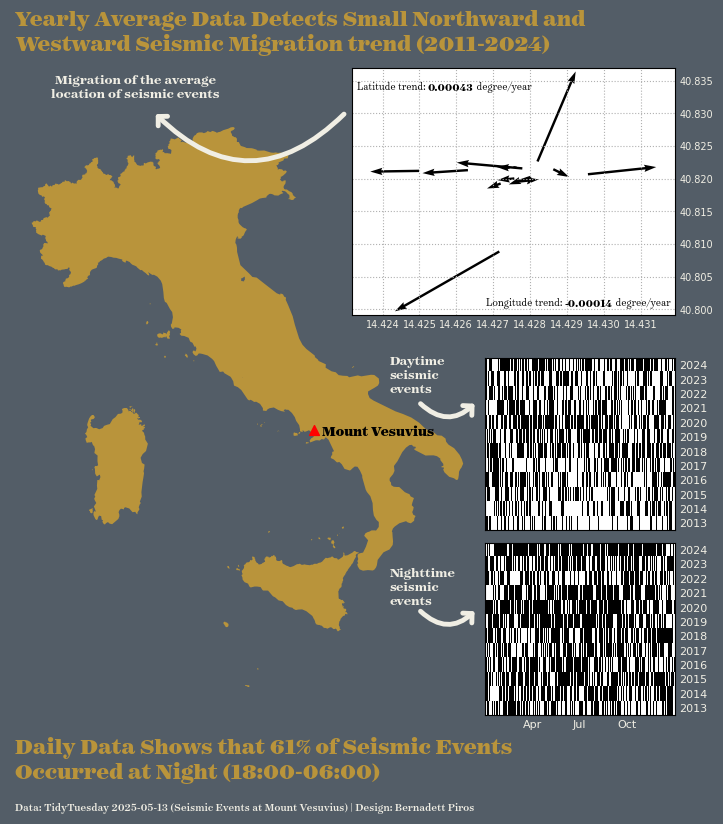

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))

italy.plot(color="#b9943b", ax=ax)

ax.scatter(14.42599, 40.82167, s=50, color="red", marker="^")
ax.text(14.65, 40.7, s="Mount Vesuvius", font=surveyor_black)

child_ax1 = ax.inset_axes([0.72, 0.65, 0.68, 0.4])
child_ax2 = ax.inset_axes([1, 0.3, 0.4, 0.28])
child_ax3 = ax.inset_axes([1, 0, 0.4, 0.28])

# Quiver plot
q = child_ax1.quiver(
    avg_locations["longitude"], avg_locations["latitude"],
    avg_locations["lon_diff"], avg_locations["lat_diff"],
    angles="xy", scale_units="xy", scale=1, color="black"
)

child_ax1.grid(True, linestyle="dotted")

offset = 0.0005  
min_lon = (avg_locations["longitude"] + avg_locations["lon_diff"]).min() - offset
max_lon = (avg_locations["longitude"] + avg_locations["lon_diff"]).max() + offset
min_lat = (avg_locations["latitude"] + avg_locations["lat_diff"]).min() - offset
max_lat = (avg_locations["latitude"] + avg_locations["lat_diff"]).max() + offset

child_ax1.set_xlim(min_lon, max_lon)
child_ax1.set_ylim(min_lat, max_lat)

child_ax1.tick_params(axis="both", labelsize=7, labelcolor="#F0EEE4")
child_ax1.tick_params(length=0)
child_ax1.yaxis.tick_right()
child_ax2.set_xticks([])

ax_text(14.4233, 40.834, f"Latitude trend: <{lat_model.coef_[0]:.5f}> degree/year", size=8, va="center", ax=child_ax1, font=surveyor_light,
              highlight_textprops=[   
             {"font":surveyor_bold}])

ax_text(14.4268, 40.801, f"Longitude trend: <{lon_model.coef_[0]:.5f}> degree/year", size=8, va="center", ax=child_ax1, font=surveyor_light,
              highlight_textprops=[   
             {"font":surveyor_bold}])

ax_arrow(
   tail_position=[15.3, 47.4],
   head_position=[10.0, 47.4],
   color="#F0EEE4",   
   fill_head=False,
   width=3.5,
   head_width=4.8,
   head_length=4.7,
   radius=-0.5,
   ax=ax,
)

ax.text(9.5, 47.7, s="Migration of the average\nlocation of seismic events", color="#F0EEE4", font=surveyor_bold, ha="center")

# Daytime event plot
daytime = daytime.copy()
daytime["doy"] = daytime["date_time"].dt.dayofyear  
daytime["event_count"] = 1

# Create a matrix (rows = years, cols = days)
years = sorted(daytime["year"].unique(), reverse=True)
max_days = 366
barcode_matrix = np.zeros((len(years), max_days))

for i, year in enumerate(years):
    year_data = daytime[daytime["year"] == year]
    binary = (year_data["event_count"] > 0).astype(int)
    days = year_data["doy"] - 1  # index starts at 0
    barcode_matrix[i, days] = binary

child_ax2.imshow(barcode_matrix, cmap="binary", aspect="auto", interpolation="nearest")

# Add year labels 
child_ax2.set_yticks(np.arange(len(years)))
child_ax2.set_yticklabels(years, fontsize=8)
child_ax2.yaxis.tick_right()
child_ax2.tick_params(length=0, labelcolor="#F0EEE4")

ax.text(16.5, 41.6, s="Daytime\nseismic\nevents", font=surveyor_bold, color="#F0EEE4")

ax_arrow(
   tail_position=[17.3, 41.4],
   head_position=[18.9, 41.4],
   color="#F0EEE4",   
   fill_head=False,
   width=3.5,
   head_width=4.8,
   head_length=4.7,
   radius=0.5,
   ax=ax,
)

# Nighttime event plot
nighttime = nighttime.copy()
nighttime["doy"] = nighttime["date_time"].dt.dayofyear  
nighttime["event_count"] = 1

# Create a matrix (rows = years, cols = days)
years = sorted(nighttime["year"].unique(), reverse=True)
max_days = 366
barcode_matrix = np.zeros((len(years), max_days))

for i, year in enumerate(years):
    year_data = nighttime[nighttime["year"] == year]
    binary = (year_data["event_count"] > 0).astype(int)
    days = year_data["doy"] - 1  # index starts at 0
    barcode_matrix[i, days] = binary

child_ax3.imshow(barcode_matrix, cmap="binary", aspect="auto", interpolation="nearest")

# Add year labels 
child_ax3.set_yticks(np.arange(len(years)))
child_ax3.set_yticklabels(years, fontsize=8)
child_ax3.yaxis.tick_right()

child_ax3.tick_params(length=0, labelcolor="#F0EEE4")
child_ax3.set_xticks([])

location = [91, 182, 274]
labels = ["Apr", "Jul", "Oct"]
child_ax3.set_xticks(location, labels=labels)

child_ax3.tick_params(
  axis="x",
  labelsize=8,
  labelcolor="#F0EEE4",
)

ax.text(16.5, 37.2, s="Nighttime\nseismic\nevents", font=surveyor_bold, color="#F0EEE4")

ax_arrow(
   tail_position=[17.3, 37.1],
   head_position=[18.9, 37.1],
   color="#F0EEE4",   
   fill_head=False,
   width=3.5,
   head_width=4.8,
   head_length=4.7,
   radius=0.5,
   ax=ax,
)

fig.text(0.28, 0.94, "Yearly Average Data Detects Small Northward and\nWestward Seismic Migration trend (2011-2024)", size=16, font=surveyor_black, color="#b9943b")

fig.text(0.28, 0.03, "Daily Data Shows that 61% of Seismic Events\nOccurred at Night (18:00-06:00)", size=16, font=surveyor_black, color="#b9943b")

fig.text(0.28, -0.01, "Data: TidyTuesday 2025-05-13 (Seismic Events at Mount Vesuvius) | Design: Bernadett Piros",
         color="#F0EEE4", size=8, font=surveyor_medium)

ax.set_axis_off()

fig.set_facecolor("#535d67")

plt.show()

#fig.savefig("2025-05-13.png", bbox_inches='tight', pad_inches=0.2)